In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def transform1(series):
    return series
def transform2(series):
    a = series.diff().fillna(0)
    return a
def transform3(series):
    a = 2* series.diff().diff().fillna(0)
    return a
def transform4(series):
    return pd.Series(np.log(series)).fillna(0)
def transform5(series):
    a = pd.Series(np.log(series)).diff().fillna(0)
    return a
def transform6(series):
    a = pd.Series(np.log(series)).diff().diff().fillna(0)
    return a
def transform7(series):
    a = series.div(series.shift(-1)).fillna(0)
    return a

functions = [transform1, transform2, transform3, transform4, transform5, transform6, transform7]

def get_transformed_data(path, transform = True, lag = 6):
    df = pd.read_csv(path)
    df2  = {}
    for name in df.columns:
        if(df[name].isna().sum() > 0 or name == 'sasdate'):
            continue
        findex = int(df[name][0])
        a = functions[findex-1](df[name][1:]) if transform else functions[1](df[name][1:])
        df2[name] = a
        df2[name] = functions[6](df[name][1:]) if findex == 6 else df2[name]
        for i in range(1,lag):
            df2[name+"_sb"+str(i)] = df2[name].shift(i).fillna(0)
    df2["beta"] = df['CPIULFSL'].rolling(10).std().fillna(np.std(df['CPIULFSL'][:10]))
    df2["max_diff"] = df['CPIULFSL'].diff().rolling(10).max().fillna(0)
    df2 = pd.DataFrame(data=df2)[1:]
    return df2

In [60]:
df = get_transformed_data('FedData/2014-12.csv', transform=False)
df

,RPI,RPI_sb1,RPI_sb2,RPI_sb3,RPI_sb4,RPI_sb5,W875RX1,W875RX1_sb1,W875RX1_sb2,W875RX1_sb3,...,MZMSL_sb4,MZMSL_sb5,INVEST,INVEST_sb1,INVEST_sb2,INVEST_sb3,INVEST_sb4,INVEST_sb5,beta,max_diff
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,1.008383,0.000000,0.000000,0.000000,0.000000,0.000000,6.928319,0.000
2,9.8,0.0,0.0,0.0,0.0,0.0,8.3,0.0,0.0,0.0,...,0.000000,0.000000,1.023284,1.008383,0.000000,0.000000,0.000000,0.000000,6.928319,0.000
3,14.8,9.8,0.0,0.0,0.0,0.0,15.9,8.3,0.0,0.0,...,0.000000,0.000000,0.997555,1.023284,1.008383,0.000000,0.000000,0.000000,6.928319,0.000
4,14.1,14.8,9.8,0.0,0.0,0.0,14.2,15.9,8.3,0.0,...,0.000000,0.000000,1.013631,0.997555,1.023284,1.008383,0.000000,0.000000,6.928319,0.000
5,14.0,14.1,14.8,9.8,0.0,0.0,15.3,14.2,15.9,8.3,...,0.996014,0.000000,1.025413,1.013631,0.997555,1.023284,1.008383,0.000000,6.928319,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,19.8,24.7,12.3,3.6,62.7,67.6,14.2,19.3,0.4,0.3,...,0.997659,0.996830,0.999647,0.991353,0.993663,0.991688,0.996279,0.993073,1.385011,0.779
668,51.7,19.8,24.7,12.3,3.6,62.7,36.8,14.2,19.3,0.4,...,0.993835,0.997659,0.993585,0.999647,0.991353,0.993663,0.991688,0.996279,1.278619,0.779
669,14.1,51.7,19.8,24.7,12.3,3.6,12.1,36.8,14.2,19.3,...,0.996645,0.993835,0.997657,0.993585,0.999647,0.991353,0.993663,0.991688,1.125517,0.779
670,39.0,14.1,51.7,19.8,24.7,12.3,40.6,12.1,36.8,14.2,...,0.993641,0.996645,0.995578,0.997657,0.993585,0.999647,0.991353,0.993663,0.993824,0.779


-0.007148194755457471
0.012554703949012974


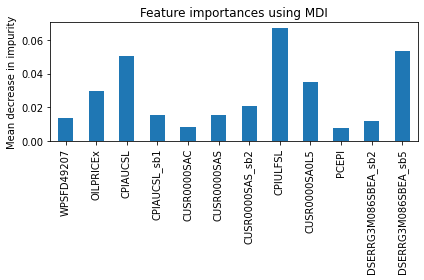

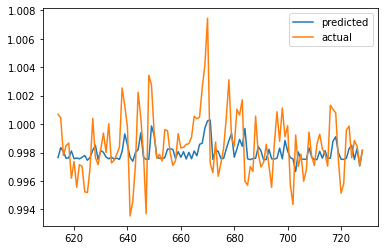

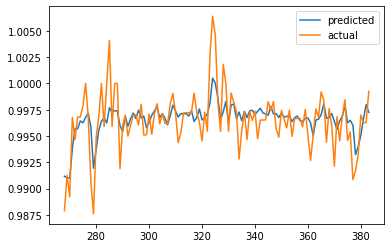

-0.005537316761867972
0.012472140826173875


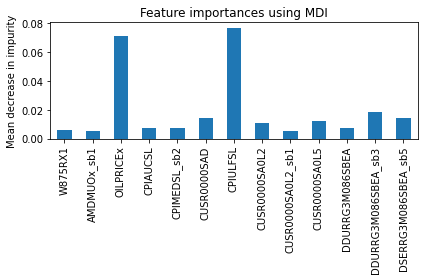

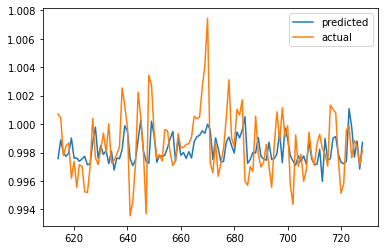

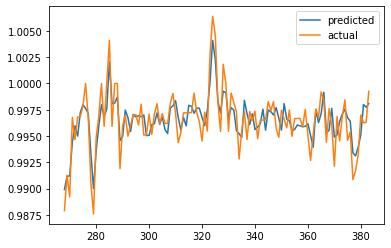

In [47]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostRegressor

df = get_transformed_data('current.csv', transform=False)
x_train, x_test, y_train, y_test = train_test_split(df, df['CPIULFSL'].shift(-1).fillna(0), shuffle=False)

models = [RandomForestRegressor(n_estimators=500, max_depth=3),
          AdaBoostRegressor(n_estimators=200)]

important_vars = set()

for l in models:
    l.fit(x_train, y_train)
    print(l.score(x_test, y_test))
    print(np.sum(np.sqrt((l.predict(x_test)-y_test)**2))*(1/len(y_test)))

    result = permutation_importance(
        l, x_train, y_train, n_repeats=10, random_state=42, n_jobs=2
    )

    forest_importances = pd.Series(result.importances_mean, index=df.columns)
    top_importance = forest_importances[forest_importances > np.std(forest_importances)+np.mean(forest_importances)]
    fig, ax = plt.subplots()
    top_importance.plot.bar(ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()
    plt.show()

    y_pred = l.predict(df)
    start, end = int(0.8*len(y_pred)), int(0.95*len(y_pred))
    plt.plot(range(start, end), y_pred[start:end], label="predicted")
    plt.plot(range(start, end), df['CPIULFSL'].shift(-1).fillna(0)[start:end], label= "actual")
    plt.legend()
    plt.show()

    start, end = int(0.35*len(y_pred)), int(0.5*len(y_pred))
    plt.plot(range(start, end), y_pred[start:end], label="predicted")
    plt.plot(range(start, end), df['CPIULFSL'].shift(-1).fillna(0)[start:end], label= "actual")
    plt.legend()
    plt.show()

    [important_vars.add(i) for i in top_importance.index]

-0.006285054848642613
0.012500979474518684


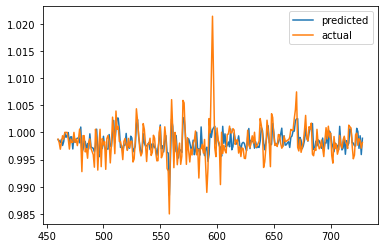

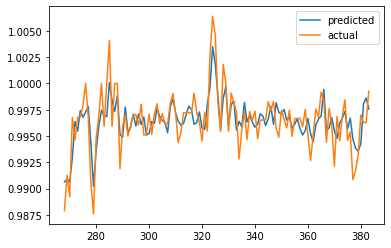

In [61]:
from sklearn.base import RegressorMixin, TransformerMixin
from sklearn.linear_model import LinearRegression, Lasso, Ridge, BayesianRidge, RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingRegressor
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator

class IdentityPassthrough(RegressorMixin):
    def __init__(self):
        pass
    def fit(self, X, y):
        return self
    def predict(self, X):
        return X

df = get_transformed_data('current.csv', transform=False)
x_train, x_test, y_train, y_test = train_test_split(df, df['CPIULFSL'].shift(-1).fillna(0), shuffle=False)

important_vars = ['AMDMUOx_sb1',
 'CPIAUCSL',
 'CPIAUCSL_sb1',
 'CPIMEDSL_sb2',
 'CPIULFSL',
 'CUSR0000SA0L2',
 'CUSR0000SA0L2_sb1',
 'CUSR0000SA0L5',
 'CUSR0000SAC',
 'CUSR0000SAD',
 'CUSR0000SAS',
 'CUSR0000SAS_sb2',
 'DDURRG3M086SBEA',
 'DDURRG3M086SBEA_sb3',
 'DSERRG3M086SBEA_sb2',
 'DSERRG3M086SBEA_sb5',
 'OILPRICEx',
 'PCEPI',
 'W875RX1',
 'WPSFD49207']

partial_passthrough = Pipeline([
    ('pass', ColumnTransformer([('pass', 'passthrough', ['beta', 'max_diff'])])),
    ('ident', IdentityPassthrough()),
])
base_features = ColumnTransformer([('pass', 'passthrough', important_vars)])

l = StackingRegressor(estimators=[
        ('pass', partial_passthrough),
        ('forest', Pipeline([('select', base_features), ('forest', RandomForestRegressor(n_estimators=500, max_depth=3))])),
        ('boost', Pipeline([('select', base_features), ('boost', AdaBoostRegressor(n_estimators=200))]))
    ], final_estimator=LinearRegression())

l.fit(x_train, y_train)
print(l.score(x_test, y_test))
print(np.sum(np.sqrt((l.predict(x_test)-y_test)**2))*(1/len(y_test)))

y_pred = l.predict(df)
start, end = int(0.6*len(y_pred)), int(0.95*len(y_pred))
plt.plot(range(start, end), y_pred[start:end], label="predicted")
plt.plot(range(start, end), df['CPIULFSL'].shift(-1).fillna(0)[start:end], label= "actual")
plt.legend()
plt.show()

start, end = int(0.35*len(y_pred)), int(0.5*len(y_pred))
plt.plot(range(start, end), y_pred[start:end], label="predicted")
plt.plot(range(start, end), df['CPIULFSL'].shift(-1).fillna(0)[start:end], label= "actual")
plt.legend()
plt.show()

In [63]:
pd.DataFrame(l.predict(df)).to_csv("new_delta_cpi.csv")